### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from feature_engine.selection import MRMR

### Load Data

In [3]:
def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required.")
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

### Initialize Metric Lists

In [5]:
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_mRMR = []
FPR_list_mRMR = []
ACC_list_mRMR = []
sample_count_list = []

### Load and Prepare Test Data

This section loads the test datasets for each attack class, assigns integer labels to each class, merges all test samples into a single test matrix and label array, and handles any missing or infinite values. This ensures the test data is clean and ready for model evaluation.

In [7]:
# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)

### MRMR Feature Selection Implementation
This cell implements the Minimum Redundancy Maximum Relevance (MRMR) feature selection algorithm, which is a sophisticated technique that selects features based on two criteria:

Maximum Relevance: Features should have high mutual information with the target variable

Minimum Redundancy: Selected features should have low mutual information with each other

The algorithm works by:

- First normalizing the data for better mutual information estimation

- Calculating a redundancy matrix that contains mutual information between all feature pairs

- Calculating relevance scores (mutual information between each feature and the target)

Iteratively selecting features that maximize the difference between relevance and average redundancy with already selected features

In [8]:
# Boucle sur P de 1 à 6
for P in range(1, 7):
    # Chargement des données d'entraînement avec P actuel
    benign_train = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 7100*P).drop(columns=['Label'], errors='ignore')
    ddos_train = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 8600*P).drop(columns=['Label'], errors='ignore')
    dos_train = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 4160*P).drop(columns=['Label'], errors='ignore')
    mirai_train = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'),2000*P).drop(columns=['Label'], errors='ignore')
    recon_train = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 3000*P).drop(columns=['Label'], errors='ignore')
    spoofing_train = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 6600*P).drop(columns=['Label'], errors='ignore')
    webbased_train = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 190*P).drop(columns=['Label'], errors='ignore')
    bruteforce_train = load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 173*P).drop(columns=['Label'], errors='ignore')

    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode Random Forest avec mRMR (using MI) ---
    sel = MRMR(
        variables=None,  # Or list of specific feature names
        method='MID',  # Try 'MIQ' for comparison
        max_features=20,  # Set to 20 as requested for feature selection
        discrete_features=False,  # Or boolean array for mixed features
        n_neighbors=3,  # Test 3, 7, 10
        scoring='accuracy',  # For 'RFCQ'
        cv=5,  # For 'RFCQ'
        param_grid=None,  # Or custom grid for 'RFCQ'
        regression=False,
        confirm_variables=False,  # Set True if using variables
        random_state=42,
        n_jobs=-1  # Parallelize for speed
    )
    sel.fit(TrainMatrix, TrainLabels)
    TrainMatrix_sel = sel.transform(TrainMatrix)
    TestMatrix_sel = sel.transform(TestMatrix)

    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_sel, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_sel)

    # Calcul métriques pour RF avec mRMR
    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_mrmr = np.diag(conf_mat_mrmr)
    FN_mrmr = np.sum(conf_mat_mrmr, axis=1) - TP_mrmr
    FP_mrmr = np.sum(conf_mat_mrmr, axis=0) - TP_mrmr
    TN_mrmr = np.sum(conf_mat_mrmr) - (TP_mrmr + FP_mrmr + FN_mrmr)

    DR_mRMR = np.mean(TP_mrmr / (TP_mrmr + FN_mrmr)) * 100
    FPR_mRMR = np.mean(FP_mrmr / (FP_mrmr + TN_mrmr)) * 100
    ACC_mRMR = np.sum(TP_mrmr) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  RF + mRMR - DR={DR_mRMR:.2f}%, FPR={FPR_mRMR:.2f}%, ACC={ACC_mRMR:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_mRMR.append(DR_mRMR)
    FPR_list_mRMR.append(FPR_mRMR)
    ACC_list_mRMR.append(ACC_mRMR)
    sample_count_list.append(len(TrainMatrix))

P=1:
  RF - DR=78.09%, FPR=0.19%, ACC=98.56%
  RF + mRMR - DR=83.36%, FPR=0.17%, ACC=98.71%
P=2:
  RF - DR=82.51%, FPR=0.17%, ACC=98.76%
  RF + mRMR - DR=86.85%, FPR=0.15%, ACC=98.91%
P=3:
  RF - DR=86.01%, FPR=0.14%, ACC=98.94%
  RF + mRMR - DR=89.23%, FPR=0.12%, ACC=99.08%
P=4:
  RF - DR=88.77%, FPR=0.12%, ACC=99.08%
  RF + mRMR - DR=91.75%, FPR=0.10%, ACC=99.23%
P=5:
  RF - DR=92.38%, FPR=0.10%, ACC=99.24%
  RF + mRMR - DR=93.49%, FPR=0.09%, ACC=99.34%
P=6:
  RF - DR=94.14%, FPR=0.08%, ACC=99.39%
  RF + mRMR - DR=95.10%, FPR=0.07%, ACC=99.49%


### Plot Performance Metrics

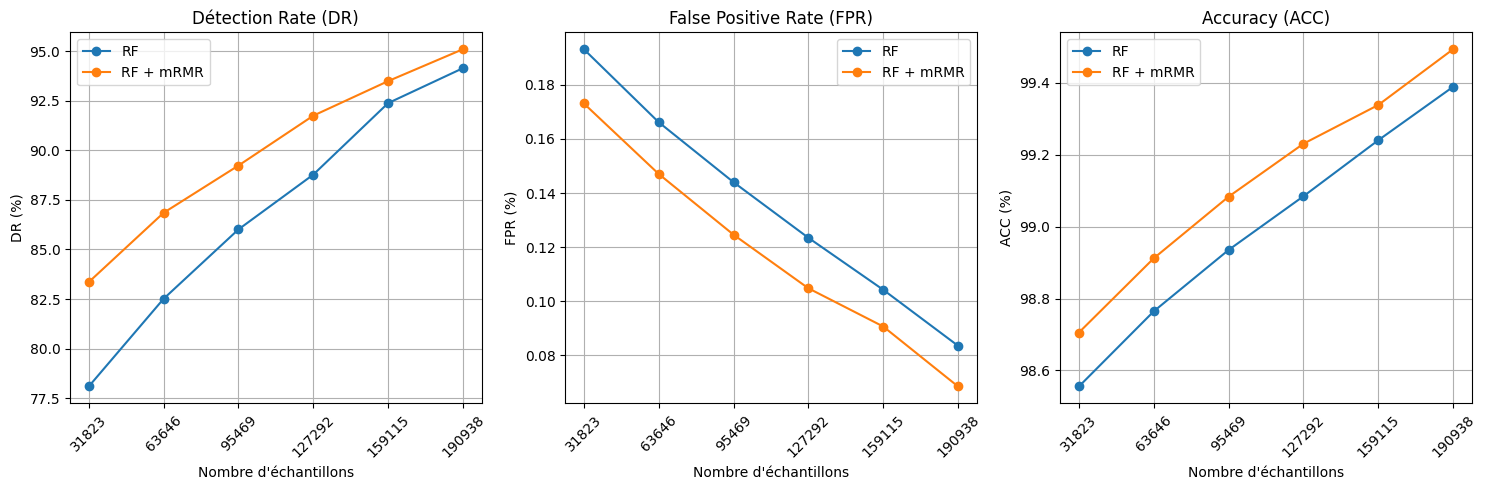

In [9]:
plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_mRMR, marker='o', label="RF + mRMR")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparison
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_mRMR, marker='o', label="RF + mRMR")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_mRMR, marker='o', label="RF + mRMR")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()